# Curling Analytics - Scoreboard Management Analysis

### Context

Scoreboard management in curling refers to managing the score and the hammer of the future ends. The team that has the hammer (last stone of the end) has the advantage to score. Once a team scores, the team that did not score in the preceding end has the hammer. If neither team scores, called a blanked end, the hammer remains with the same team.

Because of the tactical value of the hammer, the team with the hammer aims to score more than multiple points or to blank the end to keep the hammer. Teams also tends to keep the hammer in even ends so that the team will have the hammer in the last end. Often, teams need to decide how much to score with the hammer in the last few ends to maximize the chance to win.

In this analysis, I’m trying to explore how much games are won under different ends, score difference, and with or without hammer. For example, I want to how many/what percentage of games are won when at the beginning of End 8, the team with hammer is leading with 1 point?

### Preparation

In [1]:
import os
import pandas as pd
import numpy as np
import database_functions as db
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
os.environ["CADBPATH"]=os.getcwd() + "\\curling_data.db"

### Get data
In the following query, I will retrieve a dataframe that contains the information of each ends played with the final result of the game.

The field I need:
+ Game id
+ Event name
+ Type of the game (Men's/Women's) for later analysis
+ Final score of the game
+ The number of ends
+ Which team has the hammer
+ Scores of the end

In [4]:
q='''SELECT games.id AS game_id, events.name AS event_name, games.type,
games.final_score_red, games.final_score_yellow, ends.number AS end_no, ends.color_hammer,
ends.score_red AS end_score_red, ends.score_yellow AS end_score_yellow
FROM games
INNER JOIN ends ON games.id = ends.game_id
INNER JOIN events ON games.event_id = events.id
WHERE games.final_score_red != 'NaN' AND final_score_yellow != "NaN";'''

df = db.run_query(q)
df

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow
0,169,CUR_ECC2016P,Men,4,6,1,red,1.0,0.0
1,169,CUR_ECC2016P,Men,4,6,2,yellow,1.0,1.0
2,169,CUR_ECC2016P,Men,4,6,3,red,2.0,1.0
3,169,CUR_ECC2016P,Men,4,6,4,yellow,2.0,2.0
4,169,CUR_ECC2016P,Men,4,6,5,red,2.0,3.0
...,...,...,...,...,...,...,...,...,...
10201,1268,WUNI2017P,Women,3,8,5,yellow,1.0,5.0
10202,1268,WUNI2017P,Women,3,8,6,red,1.0,5.0
10203,1268,WUNI2017P,Women,3,8,7,red,3.0,5.0
10204,1268,WUNI2017P,Women,3,8,8,yellow,3.0,6.0


### Data cleasing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10206 entries, 0 to 10205
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             10206 non-null  int64  
 1   event_name          10206 non-null  object 
 2   type                10206 non-null  object 
 3   final_score_red     10206 non-null  int64  
 4   final_score_yellow  10206 non-null  int64  
 5   end_no              10206 non-null  int64  
 6   color_hammer        10206 non-null  object 
 7   end_score_red       8607 non-null   float64
 8   end_score_yellow    8607 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 717.7+ KB


The dataframe has 1599 empty rows for the scores of the ends. This is proabably due to an error when parsing the pdf reports. Although simply dropping the empty rows is probably not the best practice, I will drop the rows since the parsing error is a little hard to fix in a short time.

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8607 entries, 0 to 10205
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             8607 non-null   int64  
 1   event_name          8607 non-null   object 
 2   type                8607 non-null   object 
 3   final_score_red     8607 non-null   int64  
 4   final_score_yellow  8607 non-null   int64  
 5   end_no              8607 non-null   int64  
 6   color_hammer        8607 non-null   object 
 7   end_score_red       8607 non-null   float64
 8   end_score_yellow    8607 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 672.4+ KB


Now, the end_score column represent the scores when the end is finished. Therefore, the following is used to tranform the data:
+ Shift the hammer team up 1 row
+ Drop the last end of the game
+ Add one to the end number
Now, the end scores and hammer team represent the situation of the beginning of the end instead of when the end is finished.

In [7]:
df['color_hammer'] = df['color_hammer'].shift(periods=-1, fill_value=0)
df.drop(df.index[df.groupby('game_id')['end_no'].transform(max) == df['end_no']], inplace=True)
df['end_no'] = df['end_no']+1

Calculate the score difference for both team with hammer and the team with the first stone.

In [8]:
df['score_diff_hmr'] = np.where(df['color_hammer']=='red', df['end_score_red']-df['end_score_yellow'], df['end_score_yellow']-df['end_score_red'])
df['score_diff_fs'] = np.where(df['color_hammer']=='yellow', df['end_score_red']-df['end_score_yellow'], df['end_score_yellow']-df['end_score_red'])
df

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow,score_diff_hmr,score_diff_fs
0,169,CUR_ECC2016P,Men,4,6,2,yellow,1.0,0.0,-1.0,1.0
1,169,CUR_ECC2016P,Men,4,6,3,red,1.0,1.0,0.0,0.0
2,169,CUR_ECC2016P,Men,4,6,4,yellow,2.0,1.0,-1.0,1.0
3,169,CUR_ECC2016P,Men,4,6,5,red,2.0,2.0,0.0,0.0
4,169,CUR_ECC2016P,Men,4,6,6,red,2.0,3.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
10200,1268,WUNI2017P,Women,3,8,5,yellow,1.0,4.0,3.0,-3.0
10201,1268,WUNI2017P,Women,3,8,6,red,1.0,5.0,-4.0,4.0
10202,1268,WUNI2017P,Women,3,8,7,red,1.0,5.0,-4.0,4.0
10203,1268,WUNI2017P,Women,3,8,8,yellow,3.0,5.0,2.0,-2.0


Determine if the game is won by the team with hammer or team with the first stone.

In [9]:
df['winner_hmr'] = np.where(((df['color_hammer']=='red') & (df['final_score_red']>df['final_score_yellow']))|((df['color_hammer']=='yellow') & (df['final_score_red']<df['final_score_yellow'])),1,0)
df['winner_fs'] = np.where(((df['color_hammer']=='red') & (df['final_score_red']<df['final_score_yellow']))|((df['color_hammer']=='yellow') & (df['final_score_red']>df['final_score_yellow'])),1,0)
df.head(100)

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow,score_diff_hmr,score_diff_fs,winner_hmr,winner_fs
0,169,CUR_ECC2016P,Men,4,6,2,yellow,1.0,0.0,-1.0,1.0,1,0
1,169,CUR_ECC2016P,Men,4,6,3,red,1.0,1.0,0.0,0.0,0,1
2,169,CUR_ECC2016P,Men,4,6,4,yellow,2.0,1.0,-1.0,1.0,1,0
3,169,CUR_ECC2016P,Men,4,6,5,red,2.0,2.0,0.0,0.0,0,1
4,169,CUR_ECC2016P,Men,4,6,6,red,2.0,3.0,-1.0,1.0,0,1
5,169,CUR_ECC2016P,Men,4,6,7,yellow,3.0,3.0,0.0,0.0,1,0
6,169,CUR_ECC2016P,Men,4,6,8,red,3.0,5.0,-2.0,2.0,0,1
7,169,CUR_ECC2016P,Men,4,6,9,yellow,4.0,5.0,1.0,-1.0,1,0
8,169,CUR_ECC2016P,Men,4,6,10,yellow,4.0,5.0,1.0,-1.0,1,0
10,170,CUR_ECC2016P,Men,3,10,2,yellow,0.0,0.0,0.0,0.0,1,0


Check the distribution of the score differences

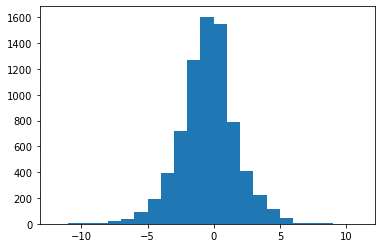

In [10]:
x1 = df['score_diff_hmr']
fig = plt.hist(x1,bins=int(x1.max()-x1.min()))

In [11]:
x1.value_counts()

-1.0     1605
 0.0     1550
-2.0     1271
 1.0      789
-3.0      720
 2.0      408
-4.0      397
 3.0      222
-5.0      196
 4.0      113
-6.0       95
 5.0       46
-7.0       34
-8.0       22
 7.0        8
-9.0        7
-10.0       6
 6.0        6
-11.0       4
 8.0        3
 9.0        2
 10.0       1
-12.0       1
 11.0       1
Name: score_diff_hmr, dtype: int64

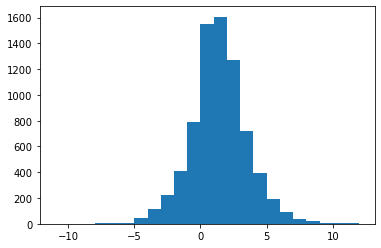

In [12]:
x2 = df['score_diff_fs']
fig = plt.hist(x2,bins=int(x2.max()-x2.min()))

In [13]:
x2.value_counts()

 1.0     1607
 0.0     1550
 2.0     1271
-1.0      787
 3.0      719
-2.0      408
 4.0      396
-3.0      223
 5.0      196
-4.0      114
 6.0       95
-5.0       46
 7.0       34
 8.0       22
-7.0        8
 9.0        7
 10.0       6
-6.0        6
 11.0       4
-8.0        3
-9.0        2
-10.0       1
 12.0       1
-11.0       1
Name: score_diff_fs, dtype: int64

As we can see from the figures and tables, the data has a rather wide spread but there are few data in both tails. Therefore, I will collapse both tails and combine them to +/-4.

In [14]:
x = df['score_diff_hmr']
con = [x<-4, (x>=-4) & (x<=4), x>4]
choice = [-4,x,4]
df['score_diff_hmr'] = np.select(con,choice)

In [15]:
x = df['score_diff_fs']
con = [x<-4, (x>=-4) & (x<=4), x>4]
choice = [-4,x,4]
df['score_diff_fs'] = np.select(con,choice)

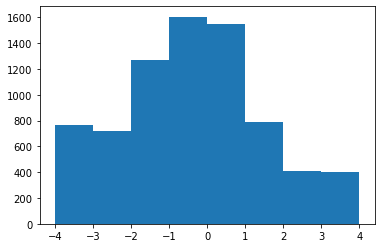

In [16]:
x1 = df['score_diff_hmr']
fig = plt.hist(x1,bins=int(x1.max()-x1.min()))

In [17]:
x1.value_counts()

-1.0    1605
 0.0    1550
-2.0    1271
 1.0     789
-4.0     762
-3.0     720
 2.0     408
 3.0     222
 4.0     180
Name: score_diff_hmr, dtype: int64

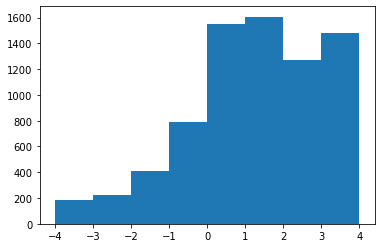

In [18]:
x2 = df['score_diff_fs']
fig = plt.hist(x2,bins=int(x2.max()-x2.min()))

In [19]:
x2.value_counts()

 1.0    1607
 0.0    1550
 2.0    1271
-1.0     787
 4.0     761
 3.0     719
-2.0     408
-3.0     223
-4.0     181
Name: score_diff_fs, dtype: int64

Attaching the total counts of each combination of hammer, end number, and score differences to the dataframe for calucating percetages later

In [20]:
df['count_hmr'] = df.groupby(['end_no','score_diff_hmr'])['winner_hmr'].transform('count')
df['count_fs'] = df.groupby(['end_no','score_diff_fs'])['winner_fs'].transform('count')
df.head(100)

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow,score_diff_hmr,score_diff_fs,winner_hmr,winner_fs,count_hmr,count_fs
0,169,CUR_ECC2016P,Men,4,6,2,yellow,1.0,0.0,-1.0,1.0,1,0,335,336
1,169,CUR_ECC2016P,Men,4,6,3,red,1.0,1.0,0.0,0.0,0,1,230,230
2,169,CUR_ECC2016P,Men,4,6,4,yellow,2.0,1.0,-1.0,1.0,1,0,203,204
3,169,CUR_ECC2016P,Men,4,6,5,red,2.0,2.0,0.0,0.0,0,1,151,151
4,169,CUR_ECC2016P,Men,4,6,6,red,2.0,3.0,-1.0,1.0,0,1,140,140
5,169,CUR_ECC2016P,Men,4,6,7,yellow,3.0,3.0,0.0,0.0,1,0,130,130
6,169,CUR_ECC2016P,Men,4,6,8,red,3.0,5.0,-2.0,2.0,0,1,116,116
7,169,CUR_ECC2016P,Men,4,6,9,yellow,4.0,5.0,1.0,-1.0,1,0,82,82
8,169,CUR_ECC2016P,Men,4,6,10,yellow,4.0,5.0,1.0,-1.0,1,0,93,93
10,170,CUR_ECC2016P,Men,3,10,2,yellow,0.0,0.0,0.0,0.0,1,0,266,266


In [21]:
df.groupby(['end_no','score_diff_hmr']).count()

game_id  event_name  type  final_score_red  \
end_no score_diff_hmr                                               
2      -4.0                 20          20    20               20   
       -3.0                 64          64    64               64   
       -2.0                216         216   216              216   
       -1.0                335         335   335              335   
        0.0                266         266   266              266   
        1.0                  1           1     1                1   
3      -4.0                 45          45    45               45   
       -3.0                 67          67    67               67   
       -2.0                174         174   174              174   
       -1.0                253         253   253              253   
        0.0                230         230   230              230   
        1.0                 88          88    88               88   
        2.0                 38          38    38               38   
        3.0                  4           4     4                4   
        4.0                  3           3     3                3   
4      -4.0                 86          86    86               86   
       -3.0                 97          97    97               97   
       -2.0                178         178   178              178   
       -1.0                203         203   203              203   
        0.0                185         185   185              185   
        1.0                 99          99    99               99   
        2.0                 32          32    32               32   
        3.0                 14          14    14               14   
        4.0                  8           8     8                8   
5      -4.0                127         127   127              127   
       -3.0                 88          88    88               88   
       -2.0                145         145   145              145   
       -1.0                186         186   186              186   
        0.0                151         151   151              151   
        1.0                115         115   115              115   
        2.0                 44          44    44               44   
        3.0                 23          23    23               23   
        4.0                 23          23    23               23   
6      -4.0                153         153   153              153   
       -3.0                101         101   101              101   
       -2.0                129         129   129              129   
       -1.0                140         140   140              140   
        0.0                145         145   145              145   
        1.0                100         100   100              100   
        2.0                 54          54    54               54   
        3.0                 39          39    39               39   
        4.0                 41          41    41               41   
7      -4.0                134         134   134              134   
       -3.0                 74          74    74               74   
       -2.0                124         124   124              124   
       -1.0                125         125   125              125   
        0.0                130         130   130              130   
        1.0                111         111   111              111   
        2.0                 70          70    70               70   
        3.0                 42          42    42               42   
        4.0                 42          42    42               42   
8      -4.0                 98          98    98               98   
       -3.0                 68          68    68               68   
       -2.0                116         116   116              116   
       -1.0                126         126   126              126   
        0.0                132         132   132              132   
        1.0          

### Analysis

Here I use the pivot_table function from pandas to generate the percentages of each situation.

In [22]:
pt_hmr = pd.pivot_table(df, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'])
pt_hmr

winner_hmr                                                    \
score_diff_hmr       -4.0      -3.0      -2.0      -1.0       0.0       1.0   
end_no                                                                        
2                0.100000  0.109375  0.203704  0.468657  0.612782  0.000000   
3                0.022222  0.119403  0.178161  0.486166  0.595652  0.795455   
4                0.046512  0.072165  0.241573  0.497537  0.616216  0.797980   
5                0.015748  0.136364  0.234483  0.403226  0.596026  0.852174   
6                0.032680  0.108911  0.248062  0.464286  0.648276  0.810000   
7                0.014925  0.135135  0.209677  0.408000  0.538462  0.873874   
8                0.030612  0.029412  0.189655  0.484127  0.628788  0.860000   
9                0.000000  0.022222  0.173469  0.387597  0.564815  0.902439   
10               0.000000  0.028169  0.153846  0.407407  0.755556  0.892473   
11                    NaN       NaN       NaN       NaN  0.646018       NaN   

                                              
score_diff_hmr       2.0       3.0       4.0  
end_no                                        
2                    NaN       NaN       NaN  
3               0.842105  1.000000  1.000000  
4               0.937500  1.000000  1.000000  
5               0.886364  0.956522  1.000000  
6               0.907407  0.974359  1.000000  
7               0.914286  0.976190  0.976190  
8               0.984375  0.974359  0.979167  
9               0.941176  0.942857  1.000000  
10              0.963636  1.000000  1.000000  
11                   NaN       NaN       NaN

In [23]:
pt_fs = pd.pivot_table(df, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'])
pt_fs

winner_fs                                                    \
score_diff_fs      -4.0      -3.0      -2.0      -1.0       0.0       1.0   
end_no                                                                      
2                   NaN       NaN       NaN       NaN  0.387218  0.529762   
3              0.000000  0.000000  0.157895  0.195402  0.404348  0.511811   
4              0.000000  0.000000  0.062500  0.193878  0.383784  0.500000   
5              0.000000  0.043478  0.111111  0.147826  0.403974  0.596774   
6              0.000000  0.025641  0.092593  0.190000  0.344828  0.535714   
7              0.023810  0.023810  0.085714  0.125000  0.453846  0.588710   
8              0.020408  0.025641  0.015625  0.140000  0.371212  0.515873   
9              0.000000  0.055556  0.040000  0.097561  0.425926  0.612403   
10             0.000000  0.000000  0.036364  0.107527  0.244444  0.592593   
11                  NaN       NaN       NaN       NaN  0.353982       NaN   

                                             
score_diff_fs       2.0       3.0       4.0  
end_no                                       
2              0.796296  0.890625  0.900000  
3              0.821839  0.880597  0.977778  
4              0.758427  0.927835  0.953488  
5              0.763889  0.863636  0.984252  
6              0.751938  0.891089  0.967320  
7              0.790323  0.864865  0.985075  
8              0.810345  0.970588  0.969072  
9              0.818182  0.977528  1.000000  
10             0.846154  0.971831  1.000000  
11                  NaN       NaN       NaN

Export the pivot tables and the dataframe to an excel file for further formatting

In [24]:
with pd.ExcelWriter('output.xlsx') as writer:  
    df.to_excel(writer, sheet_name='df')
    pt_hmr.to_excel(writer, sheet_name='pt_hmr')
    pt_fs.to_excel(writer, sheet_name='pt_fs')

PermissionError: [Errno 13] Permission denied: 'output.xlsx'